### VGGNet Modeling

##### 1.직접 구축

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

In [7]:
# Define VGG type dict
# int : output channels after conv layer
# M : max pooling layer
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}


# Define VGGNet Class
class VGGNet(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        
        # Create feature_extractor corresponding to VGG type
        self.feature_extractor = self.create_conv_layers(VGG_types[model])

        # Create classifier
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 512 * 7 * 7)
        x = self.classifier(x)
        return x

    # Define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)    
                    nn.init.constant_(m.bias, 0)

    # Define a function to create conv layers taken the key of VGG_type dict
    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels # 3
        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x
                layers += [
                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                    nn.BatchNorm2d(x),
                    nn.ReLU()
                ]
                in_channels = x   
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]        
        return nn.Sequential(*layers)


    

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
model = VGGNet('VGG16', in_channels=3, num_classes=10, init_weights=True).to(device)
print(model)

VGGNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3

In [10]:
summary(model, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [12]:
import torchvision

pet_data = torchvision.datasets.OxfordIIITPet(root="./data",split="trainval",download=True)

100.0%


Extracting data\oxford-iiit-pet\images.tar.gz to data\oxford-iiit-pet


100.0%


Extracting data\oxford-iiit-pet\annotations.tar.gz to data\oxford-iiit-pet


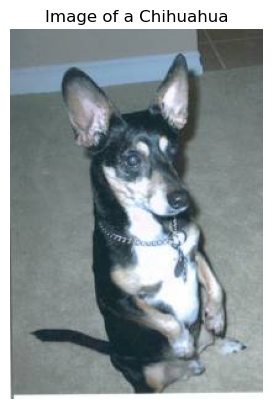

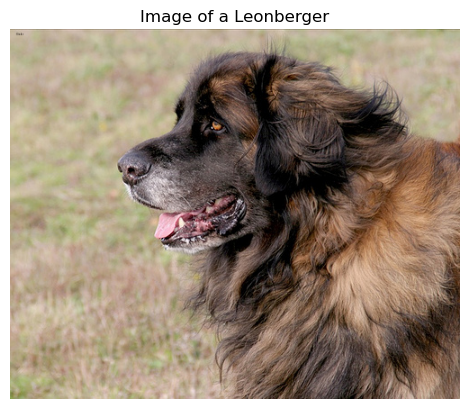

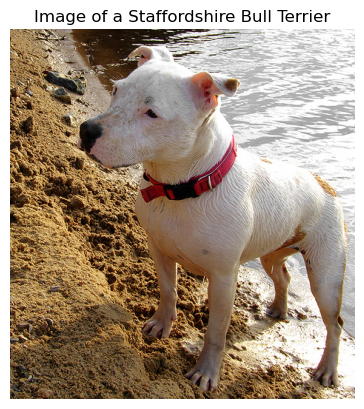

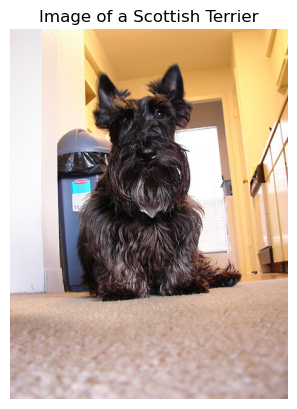

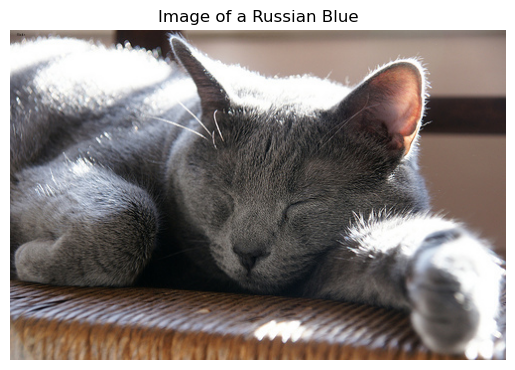

In [16]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

for i in range(5):
    image, label = pet_data[random.choice(range(len(pet_data)))]
    
    fig = plt.figure()
    plt.imshow(image)
    plt.title(f"Image of a {pet_data.classes[label]}")
    plt.axis("off")

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=0.001)

# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

In [ ]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output = model(xb)
        # Five crop : bs, crops, chnnel, h, w
        # making dimmension (bs, c, h, w)
        # bs, ncrops, c, h, w = xb.size()
        # output_=model(xb.view(-1, c, h, w))
        # output = output_.view(bs, ncrops, -1).mean(1)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [3]:
import torchvision

model = torchvision.models.vgg.vgg16(pretrained=True)

c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hyosk5\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Hyosk5/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


In [1]:
model

NameError: name 'model' is not defined